In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers
import zipfile as zf
import random

In [ ]:
pip install tensorflow==2.3.1 #Use to ensure TF 2.3.1 is used and restart kernel after installation

In [2]:
files = zf.ZipFile("dataYoupengSplit.zip",'r')
files.extractall()
files.close()

In [ ]:
print(tf.__version__) # TF Version

Generates a data object with the dataset. Splits 80/20 test/val

In [3]:
batch_size = 16
img_height = 384
img_width = 512 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  r'/content/main',
  validation_split=0.2,
  subset="training",
  seed=777,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  r'/content/main',
  validation_split=0.2,
  subset="validation",
  seed=777,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Print number of samples
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds)
)

print("The labels for the ds: %s" % train_ds.class_names)

Found 2152 files belonging to 5 classes.
Using 1722 files for training.
Found 2152 files belonging to 5 classes.
Using 430 files for validation.
Number of training samples: 108
Number of validation samples: 27
The labels for the ds: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


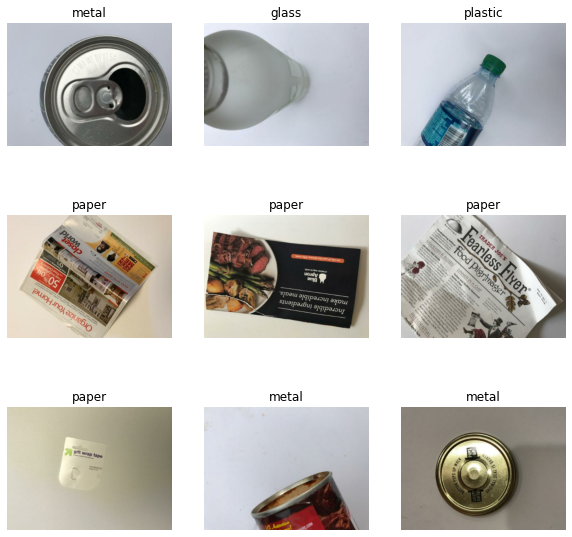

In [ ]:
#Visualise the inputs
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
#Set cache and prefetch for drive disk performance
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [5]:
#Augment training data to reduce overfitting by creating a pre-proccessing layer that only activates in training

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"), #random hor flip
        layers.experimental.preprocessing.RandomFlip("vertical"), # random ver flip
        layers.experimental.preprocessing.RandomRotation(0.5), #random rotation up to 180deg
        layers.experimental.preprocessing.RandomZoom((0,-.75)), #up to 75% zoom
    ]
)


In [ ]:
#Visualise transformations on a sample image 
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[4]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

Begin building out models!

In [ ]:
#Load EfficientNet base
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False
)

In [ ]:
#View the layers in the base model
base_model.summary()

In [7]:
# Unfreeze base model
base_model.trainable = True

# Create new model on top
inputs = keras.Input(shape=( img_height, img_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

In [50]:
#Fine-tuning: Freezes up to last N layers of base model - Use only if recreating benchmark model
#Note: Do not run if replicating WasteNet EfficientNet model.
N = 3
N = N-1
for i in range(len(base_model.layers)-N):
  base_model.layers[i].trainable=False

for j in range(len(base_model.layers)-1, len(base_model.layers)-(N-2)):
  base_model.layers[j].trainable=True

In [ ]:
#FixRes experimentation ~IGNORE~
layers = [l for l in model.layers]

new_model = keras.Sequential()

for i in range(len(layers[2].layers)-2):
  layers[2].layers[i].trainable=False
layers[2].layers[len(base_model.layers)-2].trainable=True
layers[2].layers[len(base_model.layers)-1].trainable=True

new_model.add(keras.Input(shape=(img_height, img_width, 3)))
new_model.add(layers[2])
new_model.add(layers[3])
new_model.add(layers[4])
new_model.summary()

In [8]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 384, 512, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 12, 16, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
#Train model
model.summary()

new_model.compile(
    optimizer=keras.optimizers.Adam(4.3e-5),  # Low learning rate identified by lowest loss within the first 5 epochs
    loss="sparse_categorical_crossentropy" ,
    metrics=["accuracy"],
)

epochs = 50
new_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [ ]:
#Retrain at a lower learning rate for stability (Consolidation Epochs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-6),
    loss="sparse_categorical_crossentropy" ,
    metrics=["accuracy"],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
35/35 [==============================] - 49s 1s/step - loss: 0.0675 - accuracy: 0.9801 - val_loss: 0.1798 - val_accuracy: 0.9558
Epoch 2/10
35/35 [==============================] - 42s 1s/step - loss: 0.0495 - accuracy: 0.9864 - val_loss: 0.1868 - val_accuracy: 0.9581
Epoch 3/10
35/35 [==============================] - 41s 1s/step - loss: 0.0464 - accuracy: 0.9838 - val_loss: 0.1839 - val_accuracy: 0.9581
Epoch 4/10
35/35 [==============================] - 41s 1s/step - loss: 0.0473 - accuracy: 0.9857 - val_loss: 0.1850 - val_accuracy: 0.9512
Epoch 5/10
35/35 [==============================] - 41s 1s/step - loss: 0.0483 - accuracy: 0.9834 - val_loss: 0.1897 - val_accuracy: 0.9535
Epoch 6/10
35/35 [==============================] - 41s 1s/step - loss: 0.0478 - accuracy: 0.9832 - val_loss: 0.1853 - val_accuracy: 0.9535
Epoch 7/10
35/35 [==============================] - 41s 1s/step - loss: 0.0559 - accuracy: 0.9850 - val_loss: 0.1846 - val_accuracy: 0.9558
Epoch 8/10
35/35 [==

IMPORT EXPORT

In [ ]:
#Save whole model
model.save('EfficientNetB0', include_optimizer=False) 

In [ ]:
#Load model
model = tf.keras.models.load_model('EfficientNetB0.h5')

TEST BENCH

In [79]:
#Unzip test set
files = zf.ZipFile("testtrashnet.zip",'r')
files.extractall()
files.close()

In [10]:
#Import test set as images
img = keras.preprocessing.image.DirectoryIterator(
    r'testoriginal', tf.keras.preprocessing.image.ImageDataGenerator(), target_size=(img_height, img_width), batch_size=1)

Found 238 images belonging to 5 classes.


In [ ]:
'''Calculate accuracy against test set'''
#Initiate labels and accuracy variable
labels = ["cardboard", "glass", "metal", "paper", "plastic"]
acc = 0
for i in range(len(img)):
  predictions = model.predict(img[i][0])
  for j in img[i][1]: #pull the labels of that image
    #if the models top prediction matches the label correctly then increment accuracy
    if np.argmax(predictions) == j.tolist().index(1):
      acc += 1
    #Prints 'Predicted Label : Correct Label and Confidence'
    print("%s:%s %.2f" % (labels[np.argmax(score)], labels[j.tolist().index(1)], predictions[0][np.argmax(score)]*100))
print("The accuracy against the test set was found to be: " + str((acc/len(img))*100) + "%")


In [78]:
#Zip savedmodels and export for download
!zip -r /content/B0FixRes.zip /content/EfficientNetB0_FixRes

  adding: content/EfficientNetB0_FixRes/ (stored 0%)
  adding: content/EfficientNetB0_FixRes/saved_model.pb (deflated 92%)
  adding: content/EfficientNetB0_FixRes/variables/ (stored 0%)
  adding: content/EfficientNetB0_FixRes/variables/variables.index (deflated 78%)
  adding: content/EfficientNetB0_FixRes/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/EfficientNetB0_FixRes/assets/ (stored 0%)
